In [1]:
import numpy as np
import matplotlib.pyplot as pl
import starry
import emcee
from tqdm import tqdm
import corner
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
class N(object):
    """Sample from a normal distribution."""
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
    def sample(self):
        return self.mean + self.sigma * np.random.randn()

## Let's import and look at the RV data

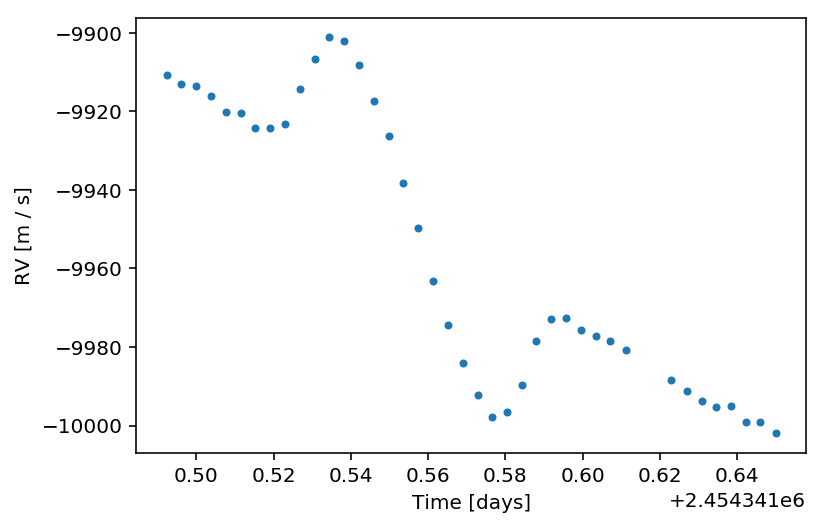

In [3]:
# RV data from Bedell
time, rv, err = np.loadtxt("HD189733_rvs.txt", unpack=True, skiprows=1, delimiter=',')
idx = np.argsort(time)
time = time[idx]
rv = rv[idx]
err = err[idx]
pl.plot(time, rv, '.')
pl.xlabel("Time [days]")
pl.ylabel("RV [m / s]");

## Planet parameters from Table 1 in Cegla et al. (2016)

In [4]:
t0 = N(2454279.436714, 0.000015)   # days
P = N(2.21857567, 0.00000015)      # days
inc = N(85.710, 0.024)             # degrees
Rstar = N(0.805, 0.016)            # solar
RpRs = N(0.15667, 0.00012)         #
aRs = N(8.863, 0.020)              #
e = N(0, 0)                        #
w = N(90, 0)                       # degrees
u1 = N(0.816, 0.019)               #
u2 = N(0, 0)                       #

## Let's start with a very simple fit
We'll assume rigid body rotation and no convective shenanigans. We'll simply draw the planet parameters from Table 1 above and fit for two primary things: the rotational velocity of the star and the stellar obliquity. We'll also fit for two nuisance parameters: the baseline and the slope due to the orbital motion of the star.

But first, let's manually tweak our parameters to get a good starting point:

In [5]:
# Uniform map for the hack below
map_unif = starry.Map(1)

# Instantiate our `starry` system
star = starry.kepler.Primary(2)
planet = starry.kepler.Secondary(0)
system = starry.kepler.System(star, planet)

# These are the params we are sampling
vstar = 3300.0
oblstar = -2.0
baseline = -9955.0
slope = -600.0

# Add rigid body rotation to the star
# HACK: We need to multiply the equatorial velocity
# by a factor of pi/sqrt(3), for two reasons:
# First, the Y_{1,1} spherical harmonic is actually
# 
#    Y_{1,1} = sqrt(3 / (4 * pi)) * x
#
# so we need star[1, 1] = vstar * sqrt(4 pi) / sqrt(3)
# to get the right normalization. Second, `starry`
# applies an implicit flux normalization of 
# sqrt(4 / pi) so that the disk-integrated flux of a
# uniform map is unity (useful for transits). We
# need to divide this out, so in the end we must do...
star[1, 1] = vstar * np.pi / np.sqrt(3)

# Let's momentarily set star[0, 0] to zero and check that
# the equatorial velocity at the eastern terminator is
# in fact `vstar`:
star[0, 0] = 0
assert np.isclose(star(x=1), vstar)

# Unfortunately, `starry` currently requires star[0, 0] = 1
# (see note below on how we correct for this)
star[0, 0] = 1

# Draw from the priors
star[1] = u1.sample()
planet.tref = t0.sample()
planet.porb = P.sample()
planet.inc = inc.sample()
planet.r = RpRs.sample()
planet.a = aRs.sample()

# Give the star an effective obliquity by
# rotating it on the sky plane
star.axis = [0, 0, 1]
star.rotate(oblstar)

# Compute the light curve
system.compute(time)

# HACK: We need to divide by the surface area of the
# star (radius = unity) to get the normalization
# correct, since what we are measuring is the
# brightness-weighted intensity normalized by the
# intensity
model = star.lightcurve / np.pi

# HACK: STARRY currently requires the Y_{0,0} coefficient for the star to be
# unity. But if we're using it to model velocity, we want the net velocity of
# the star to be *zero* (after subtracting the orbital slope). We can hack this
# by subtracting the model for a transit across a uniform star, like this:
f_unif = map_unif.flux(xo=planet.X, yo=planet.Y, ro=planet.r)
model -= f_unif

# Finally, add the baseline and the slope
model += baseline + slope * (time - time[len(time) // 2])

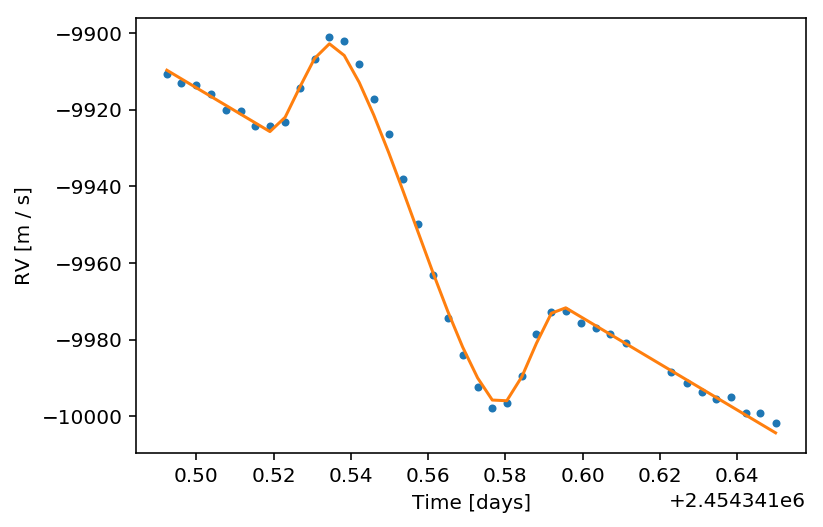

In [6]:
# Plot the model
pl.plot(time, rv, '.')
pl.plot(time, model)
pl.xlabel("Time [days]")
pl.ylabel("RV [m / s]");

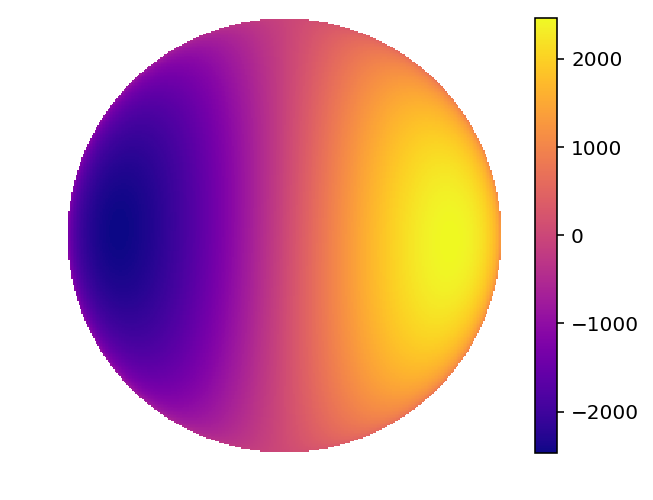

In [7]:
# Plot what the star looks like in RV
x, y = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
img = np.array([star(x=x[j], y=y[j]) for j in range(300)])
pl.imshow(img, cmap='plasma', origin='lower');
pl.gca().axis('off');
pl.colorbar();

## Now let's do MCMC

In [8]:
def lnlike(p):
    # Very wide flat priors
    vstar, oblstar, baseline, slope = p
    if (vstar < 0) or (vstar > 1e4):
        return -np.inf
    if (oblstar < -90) or (oblstar > 90):
        return -np.inf
    if (baseline < -15000) or (baseline > -5000):
        return -np.inf
    if (slope < -1000) or (slope > 0):
        return -np.inf
        
    # Reset the coeffs
    star[1:, :] = 0
    
    # Draw from the priors
    star[1] = u1.sample()
    planet.tref = t0.sample()
    planet.porb = P.sample()
    planet.inc = inc.sample()
    planet.r = RpRs.sample()
    planet.a = aRs.sample()
    blob = [star[1], planet.tref, planet.porb, planet.inc, planet.r, planet.a]
    
    # Add rigid body rotation to the star
    star[1, 1] = vstar * np.pi / np.sqrt(3)

    # Give the star an effective obliquity by
    star.rotate(oblstar)

    # Compute the light curve
    system.compute(time)

    # HACK: STARRY currently requires the Y_{0,0} coefficient for the star to be
    # unity. But if we're using it to model velocity, we want the net velocity of
    # the star to be *zero* (after subtracting the orbital slope). We can hack this
    # by subtracting the model for a transit across a uniform star, like this:
    f_unif = map_unif.flux(xo=planet.X, yo=planet.Y, ro=planet.r)
    model = star.lightcurve / np.pi - f_unif
    
    # Add a baseline
    model += baseline + slope * (time - time[len(time) // 2])
    
    # Compute the likelihood from chi-squared
    return -0.5 * np.sum(((model - rv) / err) ** 2), blob

In [9]:
# Chain params
nsteps = 50000
nwalk = 50
ndim = 4

# Initial guesses
vstar = 3300.0
oblstar = -2.0
baseline = -9955.0
slope = -600.0
p0 = [[vstar + 10 * np.random.randn(),
       oblstar + 2 * np.random.randn(),
       baseline + 3 * np.random.randn(),
       slope + 3 * np.random.randn()] for k in range(nwalk)]
labels = ['vstar', 'oblstar', 'baseline', 'slope']

# Run our MCMC chain
sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike)
for i in tqdm(sampler.sample(p0, iterations=nsteps), total=nsteps):
    pass

100%|██████████| 50000/50000 [05:01<00:00, 165.80it/s]


In [10]:
# Flatten the blobs
blobs = np.swapaxes(np.array(sampler.blobs), 0, 1).reshape(-1, 6)

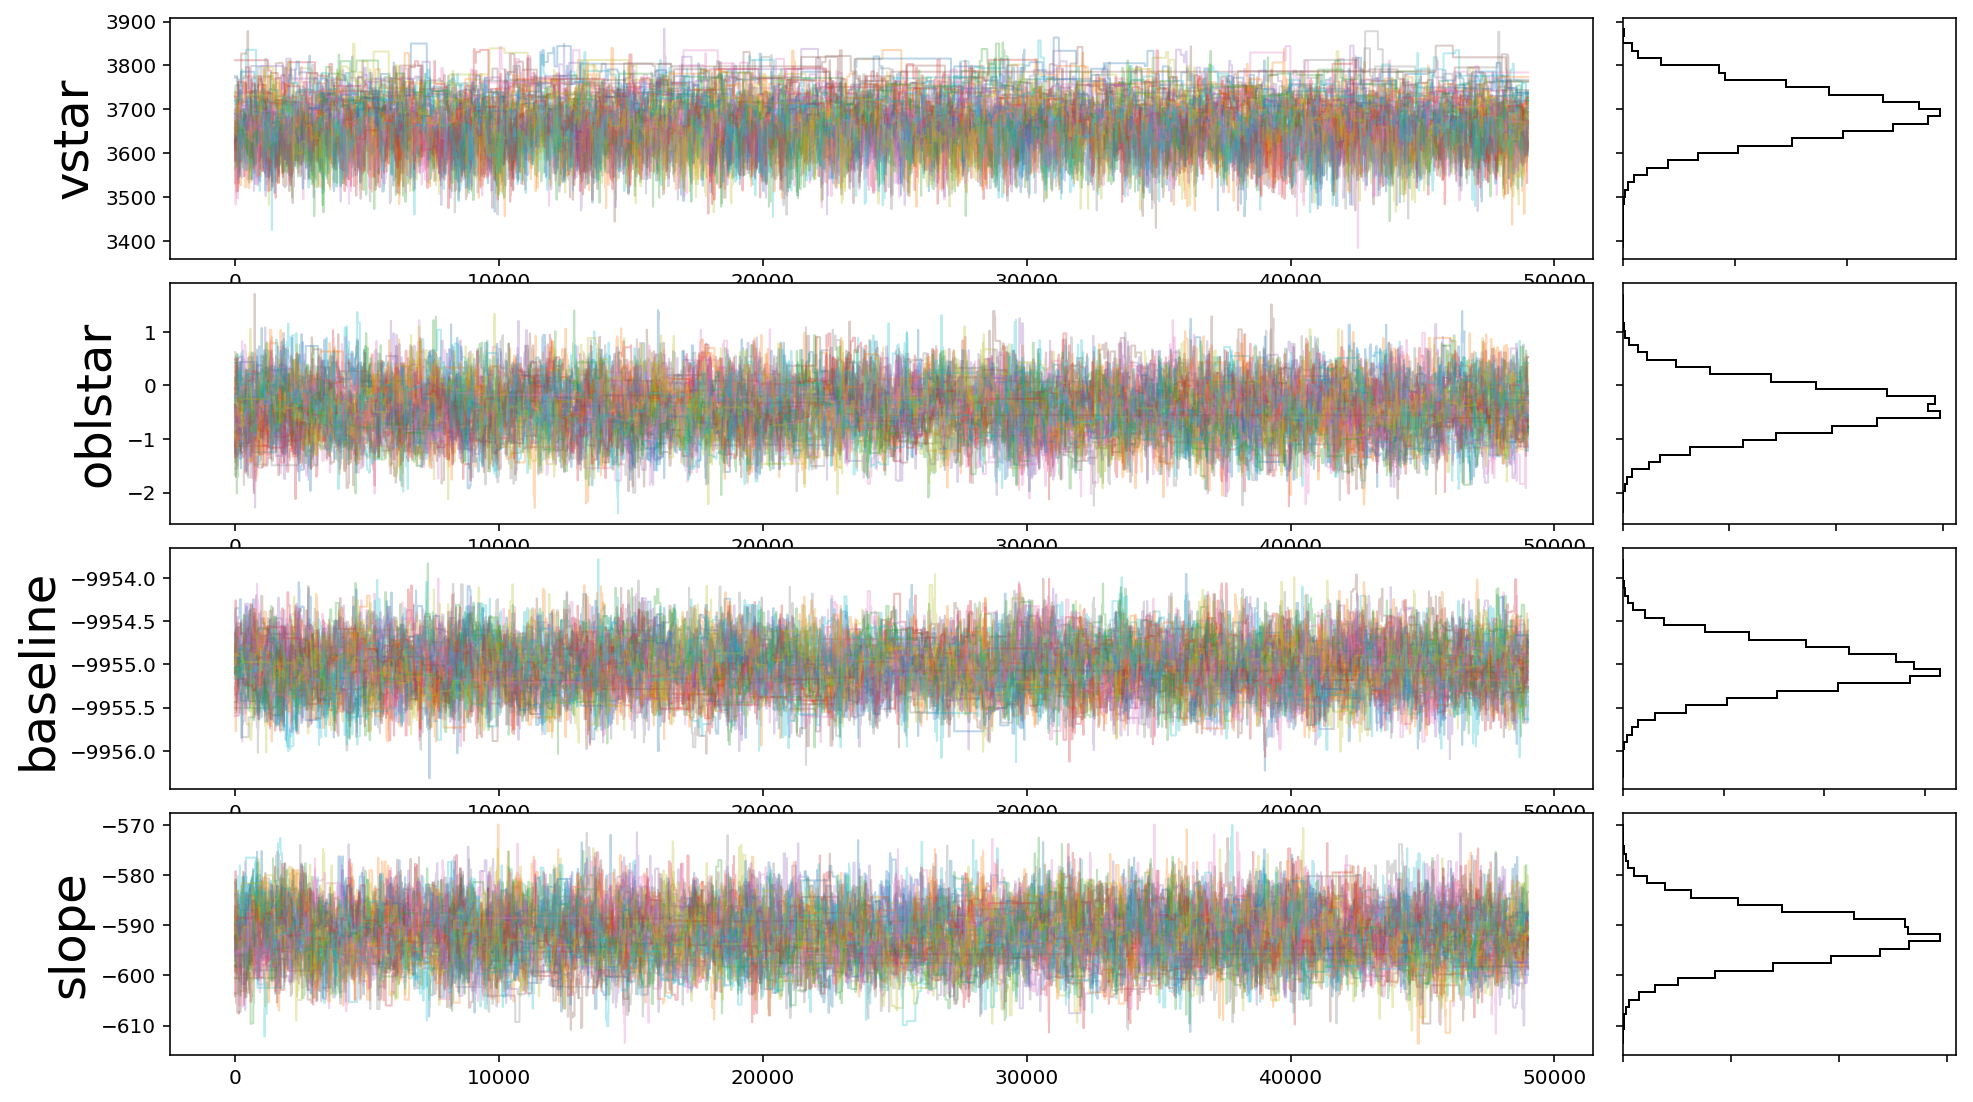

In [11]:
# Plot the chains
nburn = 1000
fig = pl.figure(figsize=(16, 8))
fig.subplots_adjust(bottom=0.05, top=0.95, hspace=0.1)
axc = [pl.subplot2grid((ndim, 10), (n, 0), colspan=8, rowspan=1)
       for n in range(ndim)]
axh = [pl.subplot2grid((ndim, 10), (n, 8), colspan=2,
                       rowspan=1, sharey=axc[n]) for n in range(ndim)]
alpha = 0.3
for i, label in enumerate(labels):
    for k in range(nwalk):
        axc[i].plot(sampler.chain[k, nburn:, i], alpha=alpha, lw=1)
        axc[i].set_ylabel(label, fontsize=24)
    axh[i].hist(sampler.chain[:, nburn:, i].flatten(), bins=30,
                orientation="horizontal", histtype='step',
                fill=False, color='k', lw=1)
    pl.setp(axh[i].get_yticklabels(), visible=False)
    pl.setp(axh[i].get_xticklabels(), visible=False)

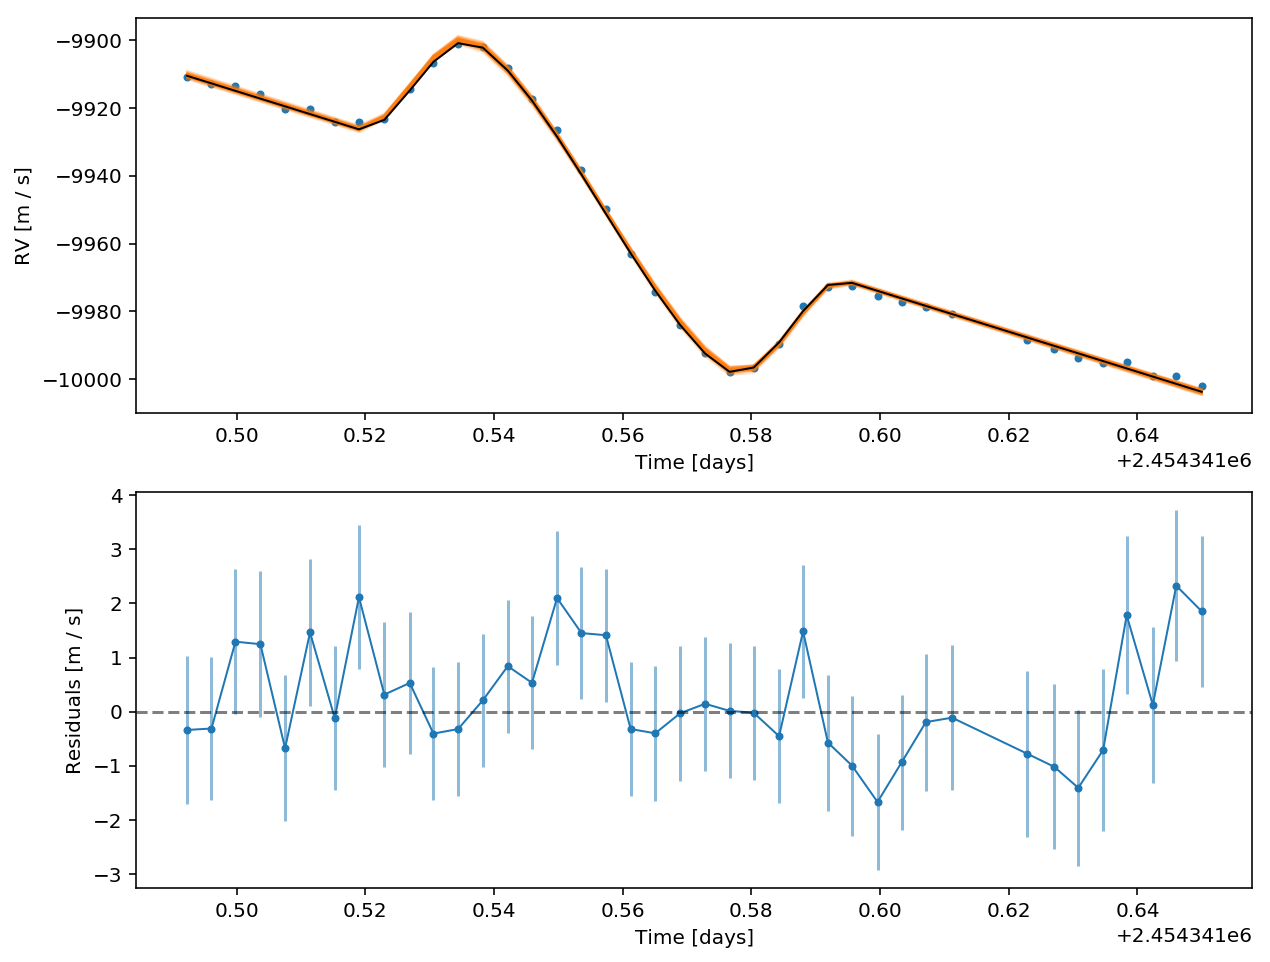

In [12]:
# Plot the data + model
fig, ax = pl.subplots(2, 1, figsize=(10, 8))
ax[0].plot(time, rv, '.')
ax[0].set_xlabel("Time [days]")
ax[0].set_ylabel("RV [m / s]");

# Plot 100 random samples
for i in range(100):
    idx = np.random.randint(0, nwalk * nsteps)
    vstar, oblstar, baseline, slope = sampler.flatchain[idx]
    star[1:, :] = 0
    star[1, 1] = vstar * np.pi / np.sqrt(3)
    star.rotate(oblstar)
    blob = blobs[idx]
    star[1], planet.tref, planet.porb, planet.inc, planet.r, planet.a = blob
    system.compute(time)
    f_unif = map_unif.flux(xo=planet.X, yo=planet.Y, ro=planet.r)
    model = star.lightcurve / np.pi - f_unif
    model += baseline + slope * (time - time[len(time) // 2])
    ax[0].plot(time, model, color='C1', alpha=0.1, lw=1)

# Plot the max like model
idx = np.argmax(sampler.flatlnprobability)
vstar, oblstar, baseline, slope = sampler.flatchain[idx]
star[1, 1] = vstar * np.pi / np.sqrt(3)
planet.Omega = -oblstar
blob = blobs[idx]
star[1], planet.tref, planet.porb, planet.inc, planet.r, planet.a = blob
system.compute(time)
f_unif = map_unif.flux(xo=planet.X, yo=planet.Y, ro=planet.r)
model = star.lightcurve / np.pi - f_unif
model += baseline + slope * (time - time[len(time) // 2])
ax[0].plot(time, model, color='k', lw=1);

# Plot the residuals
ax[1].plot(time, rv - model, '.');
ax[1].plot(time, rv - model, '-', color='C0', lw=1);
ax[1].errorbar(time, rv - model, err, fmt='none', color='C0', alpha=0.5)
ax[1].axhline(0, color='k', ls='--', alpha=0.5);
ax[1].set_xlabel("Time [days]")
ax[1].set_ylabel("Residuals [m / s]");

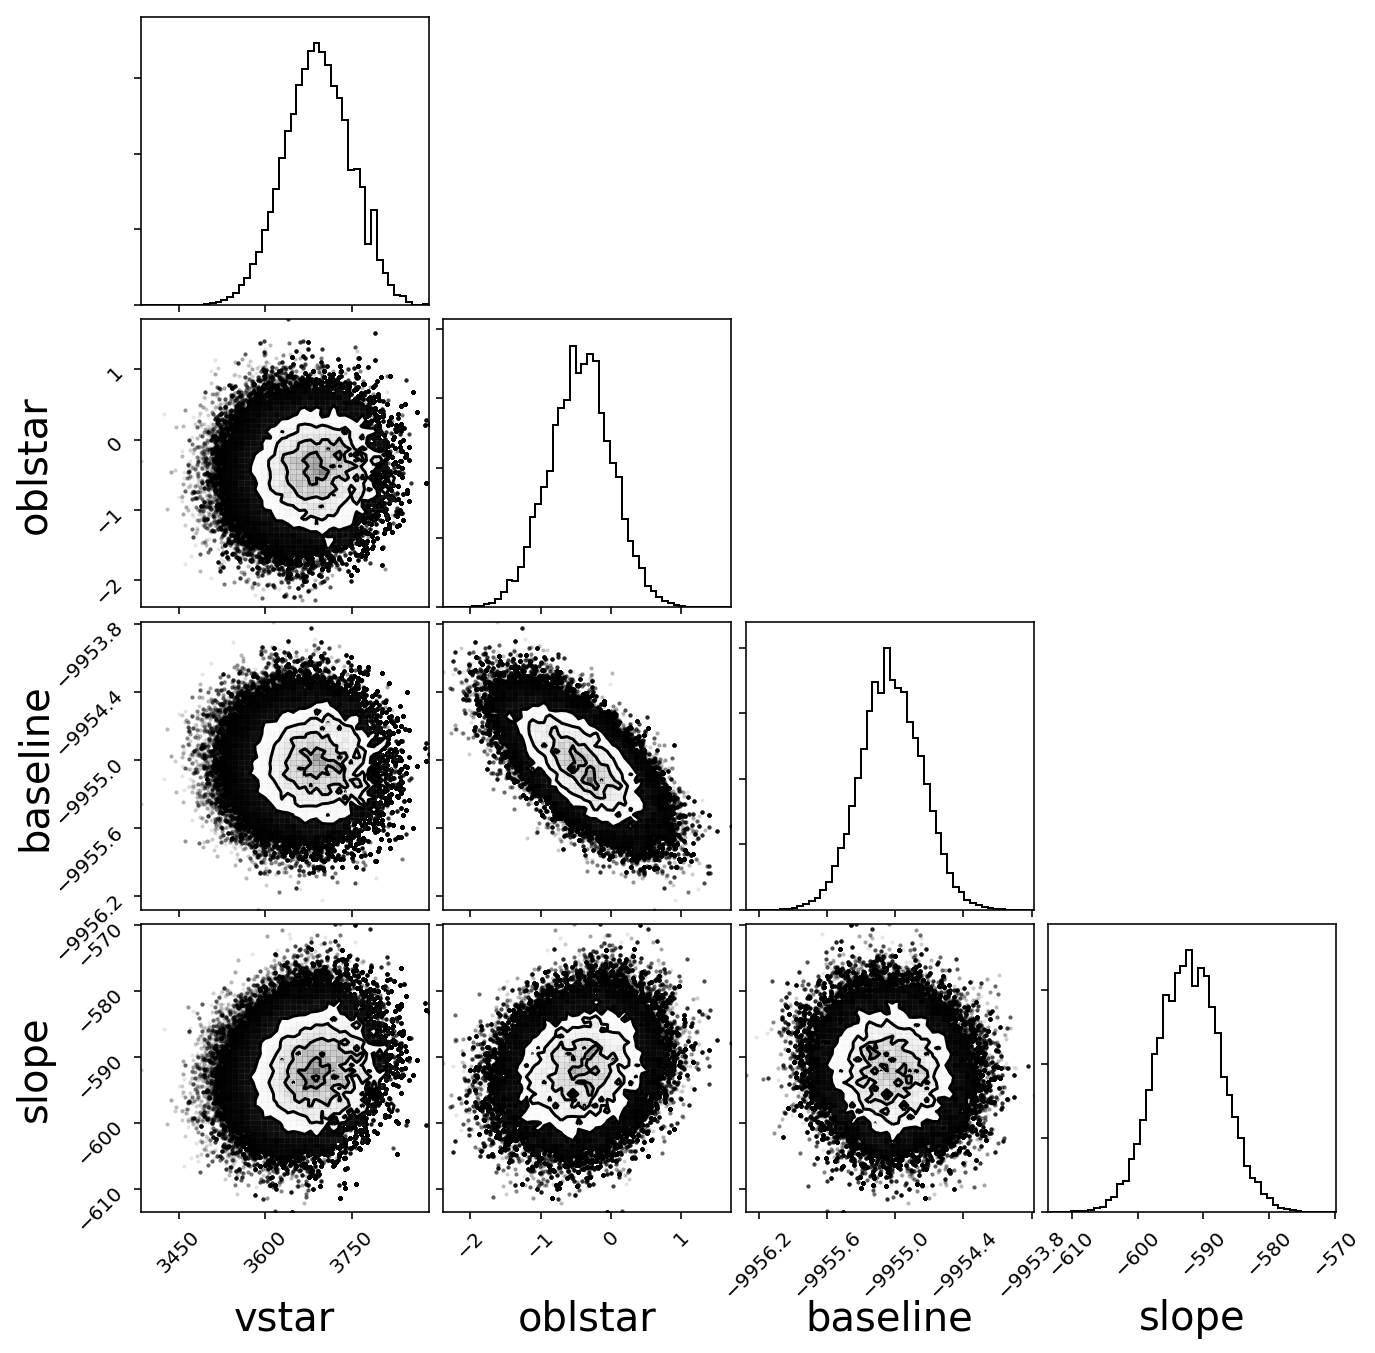

In [13]:
# Plot the corner plot for all params
samples = sampler.chain[:, nburn:, :].reshape(nwalk * (nsteps - nburn), ndim)
fig = corner.corner(samples, labels=labels, bins=50);
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

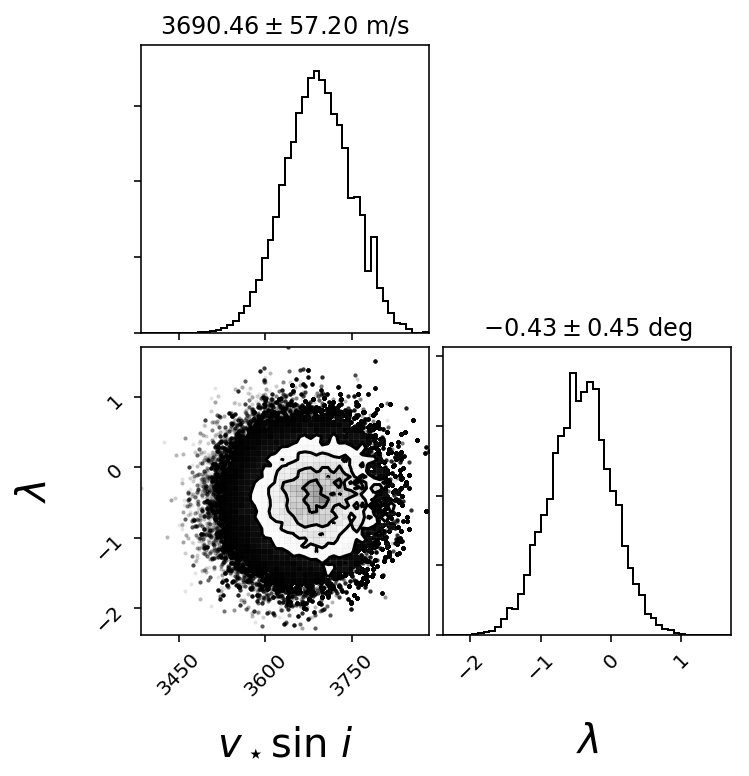

In [14]:
# Plot the corner plot for the two we care about
fig = corner.corner(samples[:, :2], labels=[r'$v_\star\sin\ i$', r'$\lambda$'], bins=50);
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
fig.axes[0].set_title(r"$%.2f \pm %.2f$ $\mathrm{m/s}$" % (np.mean(samples[:, 0]), np.std(samples[:, 0])));
fig.axes[3].set_title(r"$%.2f \pm %.2f$ deg" % (np.mean(samples[:, 1]), np.std(samples[:, 1])));

## We're nailing the stellar obliquity (Cegla et al. get $-0.4 \pm 0.2$)...
... but our $v\sin i$ is a bit high.